In [10]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import logging
from sklearn.model_selection import KFold

from copy import deepcopy

#from gensim.models import Word2Vec

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

In [11]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [12]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## Graph

In [13]:
from datasets import *


In [14]:
seed_everything(22)
use_cuda_if_available = True
    
use_cuda: bool = torch.cuda.is_available() and use_cuda_if_available
device = torch.device("cuda" if use_cuda else "cpu")

In [15]:
data_dir = "/home/minseo/Naver_Ai/data"
train_data, valid_data, test_data, n_node, user_item_sum_index = prepare_dataset(device=device, data_dir=data_dir, return_origin_train=True)

2024-01-24 19:27:21,323 - root - INFO - Train Dataset Info
2024-01-24 19:27:21,324 - root - INFO -  * Num. Users    : 7442
2024-01-24 19:27:21,324 - root - INFO -  * Max. UserID   : 7441
2024-01-24 19:27:21,324 - root - INFO -  * Num. Items    : 9454
2024-01-24 19:27:21,325 - root - INFO -  * Num. Records  : 2187529
2024-01-24 19:27:21,355 - root - INFO - val Dataset Info
2024-01-24 19:27:21,355 - root - INFO -  * Num. Users    : 7441
2024-01-24 19:27:21,356 - root - INFO -  * Max. UserID   : 7440
2024-01-24 19:27:21,356 - root - INFO -  * Num. Items    : 9454
2024-01-24 19:27:21,356 - root - INFO -  * Num. Records  : 288433
2024-01-24 19:27:21,357 - root - INFO - Test Dataset Info
2024-01-24 19:27:21,357 - root - INFO -  * Num. Users    : 744
2024-01-24 19:27:21,357 - root - INFO -  * Max. UserID   : 7439
2024-01-24 19:27:21,358 - root - INFO -  * Num. Items    : 444
2024-01-24 19:27:21,358 - root - INFO -  * Num. Records  : 744


## Model LightSGCN

In [16]:
from typing import Optional, Tuple
import scipy.sparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from lightgcn_sgcn.BPRloss import BPRLoss
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgcn_sgcn.SignedConv import SignedConv
from torch_geometric.utils import (
    coalesce,
    negative_sampling,
    structured_negative_sampling,
)


class SignedGCN(torch.nn.Module):
    r"""The signed graph convolutional network model from the `"Signed Graph
    Convolutional Network" <https://arxiv.org/abs/1808.06354>`_ paper.
    Internally, this module uses the
    :class:`torch_geometric.nn.conv.SignedConv` operator.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Size of each hidden sample.
        num_layers (int): Number of layers.
        lamb (float, optional): Balances the contributions of the overall
            objective. (default: :obj:`5`)
        bias (bool, optional): If set to :obj:`False`, all layers will not
            learn an additive bias. (default: :obj:`True`)
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        lamb: float = 5,
        bias: bool = True
    ):
        super().__init__()

        self.in_channels = in_channels
        self.x = nn.Parameter(torch.empty(16897,in_channels), requires_grad=True) ##node개수 하드코딩
        ##lightgcn weighted sum 
        alpha = 1. / (num_layers + 1)
        self.alpha = nn.ParameterList()
        for _ in range(num_layers + 1):
            self.alpha.append(nn.Parameter(torch.tensor([alpha])))
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.lamb = lamb

        self.conv1 = SignedConv(in_channels, hidden_channels // 2,
                                first_aggr=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                SignedConv(hidden_channels // 2, hidden_channels // 2,
                           first_aggr=False))

        self.lin = torch.nn.Linear(2 * hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.2)
        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        nn.init.xavier_uniform_(self.x)
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin.reset_parameters()

    def create_spectral_features(
        self,
        pos_edge_index: Tensor,
        neg_edge_index: Tensor,
        num_nodes: Optional[int] = None,
    ) -> Tensor:
        r"""Creates :obj:`in_channels` spectral node features based on
        positive and negative edges.

        Args:
            pos_edge_index (LongTensor): The positive edge indices.
            neg_edge_index (LongTensor): The negative edge indices.
            num_nodes (int, optional): The number of nodes, *i.e.*
                :obj:`max_val + 1` of :attr:`pos_edge_index` and
                :attr:`neg_edge_index`. (default: :obj:`None`)
        """
        from sklearn.decomposition import TruncatedSVD

        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        N = edge_index.max().item() + 1 if num_nodes is None else num_nodes
        edge_index = edge_index.to(torch.device('cpu'))

        pos_val = torch.full((pos_edge_index.size(1), ), 2, dtype=torch.float)
        neg_val = torch.full((neg_edge_index.size(1), ), 0, dtype=torch.float)
        val = torch.cat([pos_val, neg_val], dim=0)
        row, col = edge_index
        edge_index = torch.cat([edge_index, torch.stack([col, row])], dim=1)
        val = torch.cat([val, val], dim=0)

        edge_index, val = coalesce(edge_index, val, num_nodes=N)
        val = val - 1

        # Borrowed from:
        # https://github.com/benedekrozemberczki/SGCN/blob/master/src/utils.py
        edge_index = edge_index.detach().numpy()
        val = val.detach().numpy()
        A = scipy.sparse.coo_matrix((val, edge_index), shape=(N, N))
        svd = TruncatedSVD(n_components=self.in_channels, n_iter=128)
        svd.fit(A)
        x = svd.components_.T
        return torch.from_numpy(x).to(torch.float).to(pos_edge_index.device)

    def forward(
        self,
        pos_edge_index: Tensor,
        neg_edge_index: Tensor,
    ) -> Tensor:
        """Computes node embeddings :obj:`z` based on positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`.

        Args:
            x (torch.Tensor): The input node features.
            pos_edge_index (torch.Tensor): The positive edge indices.
            neg_edge_index (torch.Tensor): The negative edge indices.
        """
        x = self.x
        z = self.alpha[0] * self.conv1(x, pos_edge_index, neg_edge_index)
        z = self.dropout(z)
        for i,conv in enumerate(self.convs):
            z =  z + conv(z, pos_edge_index, neg_edge_index) * self.alpha[i+1]
            z = self.dropout(z)
        return z

    def discriminate(self, z: Tensor, edge_index: Tensor) -> Tensor:
        """Given node embeddings :obj:`z`, classifies the link relation
        between node pairs :obj:`edge_index` to be either positive,
        negative or non-existent.

        Args:
            x (torch.Tensor): The input node features.
            edge_index (torch.Tensor): The edge indices.
        """
        value = torch.cat([z[edge_index[0]], z[edge_index[1]]], dim=1)
        value = self.lin(value)
        return torch.sigmoid(value)

    def loss_bce(
        self,
        z: Tensor,
        edge:Tensor
    ) -> Tensor:
        """Computes the overall objective.

        Args:
            z (torch.Tensor): The node embeddings.
            pos_edge_index (torch.Tensor): The positive edge indices.
            neg_edge_index (torch.Tensor): The negative edge indices.
        """
        logit = self.discriminate(z,edge['edge'])
        label = edge['label']
        label = label.view(-1, 1).float()
        bceloss = torch.nn.BCELoss(reduction="mean")
        
        return bceloss(logit,label)

    def loss_bpr(
        self,
        z: Tensor,
        edge:Tensor
    ) -> Tensor:
        """Computes the overall objective.

        Args:
            z (torch.Tensor): The node embeddings.
            pos_edge_index (torch.Tensor): The positive edge indices.
            neg_edge_index (torch.Tensor): The negative edge indices.
        """
        logit = self.discriminate(z,edge['edge'])
        label = edge['label']
        label = label.view(-1, 1).float()
        BprLoss = BPRLoss()
        
        return BprLoss(logit,label)
    
    def test(
        self,
        z: Tensor,
        edge:Tensor,
    ) -> Tuple[float, float]:
        """Evaluates node embeddings :obj:`z` on positive and negative test
        edges by computing AUC and F1 scores.

        Args:
            z (torch.Tensor): The node embeddings.
            pos_edge_index (torch.Tensor): The positive edge indices.
            neg_edge_index (torch.Tensor): The negative edge indices.
        """
        from sklearn.metrics import f1_score, roc_auc_score

        with torch.no_grad():
            logit = self.discriminate(z,edge['edge']).cpu()
        
        label = edge['label'].cpu().numpy()
        acc = accuracy_score(y_true=label, y_pred=logit > 0.5)
        #print(logit)
        auc = roc_auc_score(y_true=label, y_score=logit)
        return auc, acc

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.hidden_channels}, num_layers={self.num_layers})')
        
    def return_emb(self):
        return self.x


# 모델

## model parameter (hyper)

In [17]:
import os
in_channels = 64
hidden_channels=64
num_layer = 3
lamb = 5
bias = True
learning_rate = 0.01
epochs = 100
num_nodes = n_node
model_dir = "./model"
if not os.path.exists(model_dir):
        os.makedirs(model_dir)
patience = 10

## 모델 생성

In [18]:
model = SignedGCN(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layer,
            lamb=lamb,
            bias=True
            ).to(device)

In [19]:
def edge_split_by_sign(edges):
    pos_from = edges['edge'][0,:][edges['label'] == 1]
    pos_dest = edges['edge'][1,:][edges['label'] == 1]
    pos_edges = torch.stack((pos_from,pos_dest))    
    
    neg_from = edges['edge'][0,:][edges['label'] == 0]
    neg_dest = edges['edge'][1,:][edges['label'] == 0]
    neg_edges = torch.stack((neg_from,neg_dest)) 
    return pos_edges, neg_edges

In [20]:
def train(model: nn.Module, train_data: dict, optimizer: torch.optim.Optimizer):
    model.train()
    optimizer.zero_grad()
    pos_edge, neg_edge = edge_split_by_sign(train_data)
    next_embedding = model(pos_edge,neg_edge)
    loss = model.loss_bce(next_embedding,train_data)
    # backward
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        auc,acc = model.test(next_embedding,train_data)
    
    logger.info("TRAIN LOSS : %.4f, Train AUC : %.4f", loss.item(), auc)
    return next_embedding, loss


def validate(valid_data: dict, model: nn.Module, embedding:torch.Tensor):
    model.eval()
    with torch.no_grad():
        pos_edge,neg_edge = edge_split_by_sign(valid_data)
        auc,acc = model.test(embedding,valid_data)
        
    logger.info("VALID AUC : %.4f", auc)
    return auc

In [21]:
optimizer =   optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
best_auc, best_epoch = 0, -1
best_emb = None
early_stopping_counter = 0
for e in range(epochs):
    logging.info("Epoch: %s", e)
    # TRAIN
    # optimizer.zero_grad()
    node_embedding, loss = train(model,train_data,optimizer)
    # VALID
    auc = validate(valid_data,model,node_embedding)
    if auc > best_auc:
        logger.info("Best model updated AUC from %.4f to %.4f", best_auc, auc)
        best_auc, best_epoch = auc, e
        best_emb = node_embedding
        torch.save(obj= {"model": model.state_dict(), "epoch": e + 1},
                    f=os.path.join(model_dir, f"best_model.pt")) 
        
        with torch.no_grad():
            print("t")
            pred = model.discriminate(node_embedding,edge_index=test_data["edge"])
            pred = pred.flatten().detach().cpu().numpy()
            os.makedirs(name="./submit/", exist_ok=True)
            write_path = os.path.join("./submit/", "submission_t.csv")
            pd.DataFrame({"prediction": pred}).to_csv(path_or_buf=write_path, index_label="id")
            
        
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            break
torch.save(obj={"model": model.state_dict(), "epoch": e + 1},
            f=os.path.join(model_dir, f"last_model.pt"))
logger.info(f"Best Weight Confirmed : {best_epoch+1}'th epoch")

2024-01-24 19:27:27,259 - root - INFO - Epoch: 0
2024-01-24 19:27:28,515 - root - INFO - TRAIN LOSS : 0.6854, Train AUC : 0.5023
2024-01-24 19:27:28,578 - root - INFO - VALID AUC : 0.4999
2024-01-24 19:27:28,578 - root - INFO - Best model updated AUC from 0.0000 to 0.4999
t
2024-01-24 19:27:28,628 - root - INFO - Epoch: 1
2024-01-24 19:27:29,299 - root - INFO - TRAIN LOSS : 0.6696, Train AUC : 0.5354
2024-01-24 19:27:29,361 - root - INFO - VALID AUC : 0.5329
2024-01-24 19:27:29,362 - root - INFO - Best model updated AUC from 0.4999 to 0.5329
t
2024-01-24 19:27:29,410 - root - INFO - Epoch: 2
2024-01-24 19:27:30,069 - root - INFO - TRAIN LOSS : 0.6539, Train AUC : 0.5837
2024-01-24 19:27:30,131 - root - INFO - VALID AUC : 0.5819
2024-01-24 19:27:30,132 - root - INFO - Best model updated AUC from 0.5329 to 0.5819
t
2024-01-24 19:27:30,182 - root - INFO - Epoch: 3
2024-01-24 19:27:30,845 - root - INFO - TRAIN LOSS : 0.6402, Train AUC : 0.6376
2024-01-24 19:27:30,907 - root - INFO - VALID 

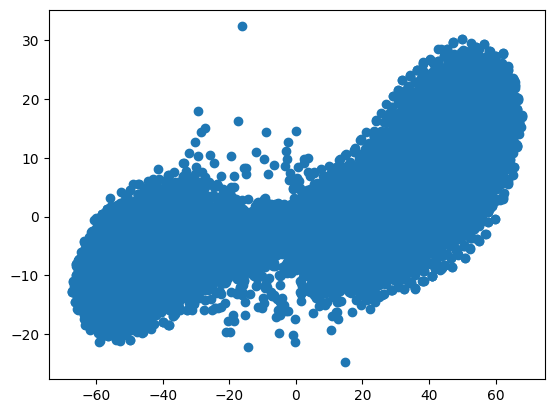

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model2 = TSNE(n_components=n_components)
saved_emb = best_emb.clone().to('cpu')
# 학습한 결과 2차원 공간 값 출력
emb2d = model2.fit_transform(best_emb.to('cpu').detach().numpy())
plt.scatter(emb2d[7441:, 0], emb2d[7441:, 1])
plt.show()


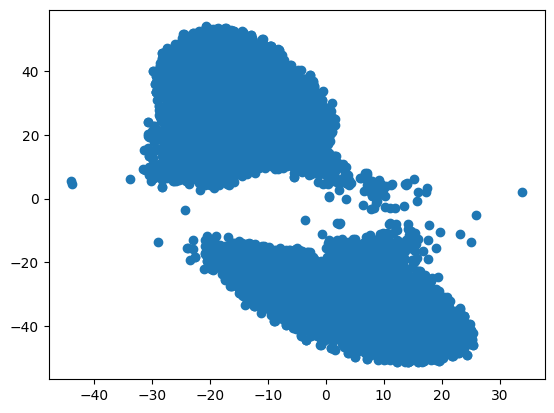

In [23]:
plt.scatter(emb2d[:7441, 0], emb2d[:7441, 1])
plt.show()

In [15]:
best_emb.size()
from numba import cuda
device_temp = cuda.get_current_device() 
device_temp.reset()

2024-01-24 03:23:19,682 - numba.cuda.cudadrv.driver - INFO - init
2024-01-24 03:23:19,683 - numba.cuda.cudadrv.driver - INFO - reset context of device 0


In [16]:
saved_emb.to('cpu')
saved_emb.detach()

tensor([[-0.0000e+00, -1.1341e-01, -9.1684e-02,  ..., -0.0000e+00, -2.1394e-01, 8.0507e-02],
        [-0.0000e+00, -1.1079e-01, -8.5243e-02,  ..., -6.7236e-03, -2.1078e-01, 4.0087e-02],
        [-0.0000e+00, -5.8085e-02, -1.8330e-03,  ..., -1.1793e-02, -1.7338e-01, 4.4415e-02],
        ...,
        [-0.0000e+00, -1.0881e-01, -1.4012e-01,  ..., 6.8572e-02, -2.2740e-01, 1.0130e-01],
        [-1.7802e-02, -0.0000e+00, -1.6651e-01,  ..., 7.2111e-02, -2.0752e-01, 0.0000e+00],
        [-0.0000e+00, -9.1205e-02, -1.0401e-01,  ..., -1.2449e-02, -1.6775e-01, 3.2655e-02]])

In [17]:
class MakeDataset():

    def __init__(self, DATA_PATH):
        self.preporcessing(DATA_PATH)
        self.oof_user_set = self.split_data()
    
    def split_data(self):
        user_list = self.all_df['userID'].unique().tolist()
        oof_user_set = {}
        kf = KFold(n_splits = 5, random_state = 22, shuffle = True)
        for idx, (train_user, valid_user) in enumerate(kf.split(user_list)):
            oof_user_set[idx] = valid_user.tolist()
        
        return oof_user_set

    def preporcessing(self, DATA_PATH):

        dtype = {
            'userID': 'int16',
            'KnowledgeTag': 'int16',            
        }
        
        train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data_3PL_FE.csv'), dtype=dtype, parse_dates=['Timestamp'])
        train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
        train_df['answerCode'] = train_df['answerCode'].astype(int)
        test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data_3PL_FE.csv'), dtype=dtype, parse_dates=['Timestamp'])
        test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
        test_df['answerCode'] = test_df['answerCode'].astype(int)
        all_df = pd.concat([train_df, test_df])
        all_df = all_df[all_df['answerCode'] != -1].reset_index(drop = True)

        # index 로 변환
        def get_val2idx(val_list : list) -> dict:
            val2idx = {}
            for idx, val in enumerate(val_list):
                val2idx[val] = idx
            
            return val2idx

        train_df['assessmentItemID2idx'] = train_df['assessmentItemID'].apply(lambda x : user_item_sum_index[x])
        test_df['assessmentItemID2idx'] = test_df['assessmentItemID'].apply(lambda x : user_item_sum_index[x])
        self.train_df, self.test_df = train_df, test_df
        self.all_df = pd.concat([train_df, test_df[test_df['answerCode'] != -1]]).reset_index(drop=True)

        
    def get_oof_data(self, oof):

        val_user_list = self.oof_user_set[oof]

        train = []
        valid = []

        group_df = self.all_df.groupby('userID')

        for userID, df in group_df:
            if userID in val_user_list:
                trn_df = df.iloc[:-1, :]
                val_df = df.copy()
                train.append(trn_df)
                valid.append(val_df)
            else:
                train.append(df)

        # normalize_score
        def get_normalize_score(df, all_df, vailid = False):
            ret_df = []

            group_df = df.groupby('userID')
            mean_answerCode_df = all_df.groupby('testId').mean()['answerCode']
            std_answerCode_df = all_df.groupby('testId').std()['answerCode']
            for userID, get_df in group_df:
                if vailid:
                    normalize_score_df = (get_df.iloc[:-1, :].groupby('testId').mean()['answerCode'] - mean_answerCode_df) / std_answerCode_df
                else:
                    normalize_score_df = (get_df.groupby('testId').mean()['answerCode'] - mean_answerCode_df) / std_answerCode_df
                    
                get_df = get_df.copy().set_index('testId')
                get_df['normalize_score'] = normalize_score_df
                ret_df.append(get_df.reset_index(drop =False))

            ret_df = pd.concat(ret_df).reset_index(drop = True)
            
            return ret_df

        train = pd.concat(train).reset_index(drop = True)
        valid = pd.concat(valid).reset_index(drop = True)

        # train = get_normalize_score(df = train, all_df = train)
        # valid = get_normalize_score(df = valid, all_df = train, vailid = True)
        
        return train, valid
    
    def get_test_data(self):
        return self.test_df.copy()

In [127]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        df,
        max_len = None,
        window = None,
        ):
     
        self.get_df = df.groupby('userID')
        self.user_list = df['userID'].unique().tolist()
        self.max_len = max_len
        self.window = window


    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
            user = self.user_list[idx]
            if self.max_len:
                get_df = self.get_df.get_group(user).iloc[-self.max_len:, :]
            else:
                get_df = self.get_df.get_group(user)

            now_df = get_df.iloc[1:, :]
            now_node_feature = now_df['assessmentItemID2idx'].values
            now_answerCode = now_df['answerCode'].values

            past_df = get_df.iloc[:-1, :]
            past_node_feature = past_df['assessmentItemID2idx'].values
            past_answerCode = past_df['answerCode'].values

            return {
            'past_node_feature' : past_node_feature,  
            'past_answerCode' : past_answerCode, 
            'now_node_feature' : now_node_feature,  
            'now_answerCode' : now_answerCode
            }
            
def pad_sequence(seq, max_len, padding_value = 0):
    try:
        seq_len, col = seq.shape
        padding = np.zeros((max_len - seq_len, col)) + padding_value
    except:
        seq_len = seq.shape[0]
        padding = np.zeros((max_len - seq_len, )) + padding_value

    padding_seq = np.concatenate([padding, seq])

    return padding_seq

def train_make_batch(samples):
    max_len = 0
    for sample in samples:
        seq_len = len(sample['past_answerCode'])
        if max_len < seq_len:
            max_len = seq_len
    
    past_node_feature = []
    past_answerCode = []
    now_node_feature = []
    now_answerCode = []

    for sample in samples:
        past_node_feature += [pad_sequence(sample['past_node_feature'] + 1, max_len = max_len, padding_value = -1)]
        past_answerCode += [pad_sequence(sample['past_answerCode'] + 1, max_len = max_len, padding_value = 2)]
        now_node_feature += [pad_sequence(sample['now_node_feature'] + 1, max_len = max_len, padding_value = -1)]
        now_answerCode += [pad_sequence(sample['now_answerCode'], max_len = max_len, padding_value = 2)]

    return torch.tensor(past_node_feature, dtype = torch.long), torch.tensor(past_answerCode, dtype = torch.long), torch.tensor(now_node_feature, dtype = torch.long), torch.tensor(now_answerCode, dtype = torch.float32)

# 학습

In [151]:
batch_size = 128
epochs = 20
lr = 1e-03
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

emb_size = 64
hidden_units = 128
num_heads = 2 # 2,4,8,16,32
num_layers = 1
dropout_rate = 0.5
num_workers = 8

max_len = 50
window = 10
data_augmentation = False

DATA_PATH = '/home/minseo/Naver_Ai/data'
MODEL_PATH = './model/DA111/'
SUBMISSION_PATH = './submission/DA111/'

model_name = 'Transformer-and-LSTM-Encoder-Decoder-each-Embedding-num_heads-2-Scheduler.pt'
submission_name = 'Transformer-and-LSTM-Encoder-Decoder-each-Embedding-num_heads-2-Scheduler.csv'

In [152]:
make_dataset = MakeDataset(DATA_PATH = DATA_PATH)

In [153]:
train_df, valid_df = make_dataset.get_oof_data(1)
train_dataset = CustomDataset(df = train_df)
train_data_loader = DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
    drop_last = False,
    collate_fn = None,
    num_workers = num_workers)

valid_dataset = CustomDataset(df = valid_df)
valid_data_loader = DataLoader(
    valid_dataset, 
    batch_size = 1, 
    shuffle = False, 
    drop_last = False,
    collate_fn = None,
    num_workers = num_workers)

In [154]:
saved_emb = saved_emb.detach()
saved_emb

tensor([[-0.0000e+00, -1.1341e-01, -9.1684e-02,  ..., -0.0000e+00, -2.1394e-01, 8.0507e-02],
        [-0.0000e+00, -1.1079e-01, -8.5243e-02,  ..., -6.7236e-03, -2.1078e-01, 4.0087e-02],
        [-0.0000e+00, -5.8085e-02, -1.8330e-03,  ..., -1.1793e-02, -1.7338e-01, 4.4415e-02],
        ...,
        [-0.0000e+00, -1.0881e-01, -1.4012e-01,  ..., 6.8572e-02, -2.2740e-01, 1.0130e-01],
        [-1.7802e-02, -0.0000e+00, -1.6651e-01,  ..., 7.2111e-02, -2.0752e-01, 0.0000e+00],
        [-0.0000e+00, -9.1205e-02, -1.0401e-01,  ..., -1.2449e-02, -1.6775e-01, 3.2655e-02]])

In [155]:
class SASRec(nn.Module):
    def __init__(
        self, 
        node_feature,
        emb_size,
        num_layers, 
        dropout_rate, 
        device):
        super(SASRec, self).__init__()
      
        self.node_feature = node_feature
        self.emb_layernorm = nn.LayerNorm(emb_size, eps=1e-6)
        self.answer_embed = nn.Embedding(3,emb_size, padding_idx=2) 
        self.node_padding = torch.zeros(emb_size)
        self.now_lstm = nn.LSTM(
            input_size = emb_size*2,
            hidden_size = emb_size*2,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = dropout_rate,
            )
        # predict
        self.dropout = nn.Dropout(dropout_rate)
        self.predict_layer = nn.Sequential(
            nn.Linear(emb_size * 2, 1),
            nn.Sigmoid()
        )
        self.num_layers = num_layers
        self.device = device
    
    
    def forward(self, questions, answer_code):
        answer_code = self.answer_embed(answer_code.to(device))
        
        questions_batch = []
        for i in questions:
            sequence_temp = []
            for j in i:
                if j == -1:
                    sequence_temp.append(self.node_padding)
                else : # j != -1
                    sequence_temp.append(self.node_feature[j.item(),:])
            questions_batch.append(torch.stack(sequence_temp))
        questions_batch = torch.stack(questions_batch).to(self.device)
        all_feature = torch.concat((questions_batch,answer_code),dim=2)
        output = self.predict_layer(self.dropout(all_feature))
        
        return output

In [158]:
from sklearn.metrics import roc_auc_score

def train(model, data_loader, criterion, optimizer):
    model.train()
    loss_val = 0

    for _,pred_answer_code,node_feature_idx,criterion_answer_code in data_loader:

        optimizer.zero_grad()

        output = model(node_feature_idx, pred_answer_code).squeeze(2)
        loss = criterion(output[criterion_answer_code != 2].to('cpu'), criterion_answer_code[criterion_answer_code != 2].to('cpu'))
        loss.backward()
        optimizer.step()

        loss_val += loss.item()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader):
    model.eval()

    target = []
    pred = []

    with torch.no_grad():
        for _,pred_answer_code,node_feature_idx,criterion_answer_code in data_loader:
            output = model(node_feature_idx, pred_answer_code).squeeze(2)
            target.extend(criterion_answer_code[:, -1].cpu().numpy().tolist())
            pred.extend(output[:, -1].cpu().numpy().tolist())

    roc_auc = roc_auc_score(target, pred)

    return roc_auc


def predict(model, data_loader):
    model.eval()

    pred = []

    with torch.no_grad():
        for past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature, now_answerCode in data_loader:
            past_cat_feature, past_num_feature, past_answerCode = past_cat_feature.to(device), past_num_feature.to(device), past_answerCode
            now_cat_feature, now_num_feature = now_cat_feature.to(device), now_num_feature.to(device)
            
            output = model(past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature).squeeze(2)
            pred.extend(output[:, -1].cpu().numpy().tolist())

    return pred

# OOF Ensemble

In [159]:
oof_roc_auc = 0

for oof in make_dataset.oof_user_set.keys():
    train_df, valid_df = make_dataset.get_oof_data(oof)
    
    seed_everything(22 + oof)
    
    train_dataset = CustomDataset(df = train_df)
    train_data_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = train_make_batch,
        num_workers = num_workers)

    valid_dataset = CustomDataset(df = valid_df)
    valid_data_loader = DataLoader(
        valid_dataset, 
        batch_size = 1, 
        shuffle = False, 
        drop_last = False,
        collate_fn = train_make_batch,
        num_workers = num_workers)

    model = SASRec(
        node_feature = saved_emb,
        emb_size = 64,
        num_layers = 2, 
        dropout_rate = 0.5, 
        device = device
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.BCELoss()

    # pre_emb = Word2Vec.load(os.path.join(MODEL_PATH, 'Word2Vec_Embedding_Model_window_50.model'))

    # assessmentItemID_li = make_dataset.assessmentItemID2idx.keys()

    # with torch.no_grad():
    #     for assessmentItemID in assessmentItemID_li:
    #         idx = make_dataset.assessmentItemID2idx[assessmentItemID]
    #         model.assessmentItemID_emb.weight[idx + 1] = torch.tensor(pre_emb.wv[assessmentItemID]).to(device)

    best_epoch = 0
    best_train_loss = 0
    best_roc_auc = 0

    for epoch in range(1, epochs + 1):
        tbar = tqdm(range(1))
        for _ in tbar:
            train_loss = train(model = model, data_loader = train_data_loader, criterion = criterion, optimizer = optimizer)
            roc_auc = evaluate(model = model, data_loader = valid_data_loader)
            if best_roc_auc < roc_auc:
                best_epoch = epoch
                best_train_loss = train_loss
                best_roc_auc = roc_auc
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'oof_{oof}_' + model_name))

            tbar.set_description(f'OOF-{oof}| Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| roc_auc: {roc_auc:.5f}')
    
    print(f'BEST OOF-{oof}| Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| roc_auc: {best_roc_auc:.5f}')

    oof_roc_auc += best_roc_auc

print(f'Total roc_auc: {oof_roc_auc / len(make_dataset.oof_user_set.keys()):.5f}')

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(7.0086e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.9829e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.9590e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.9404e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.9205e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.9187e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8825e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8575e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8585e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8253e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8320e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.8336e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7808e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7705e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7742e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7340e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7530e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.7318e

OOF-0| Epoch:   1| Train loss: 0.65794| roc_auc: 0.66315: 100%|██████████| 1/1 [00:46<00:00, 46.32s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

tensor(6.3159e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.3802e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2514e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1845e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2090e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2440e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2474e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1199e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2647e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2250e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2534e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2252e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1221e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1846e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1209e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1035e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.2266e-01, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.1937e

# 예측